# DST Impact on the way people go to gym

# DataSet
The dataset is taken from [here](https://www.kaggle.com/nsrose7224/crowdedness-at-the-campus-gym/version/2)
## Description
The dataset consists of 26,000 people counts (about every 10 minutes) over the last year. In addition, I gathered extra info including weather and semester-specific information that might affect how crowded it is. The label is the number of people, which I'd like to predict given some subset of the features.

Features:
* __date__ (string; datetime of data)
* __timestamp__ (int; number of seconds since beginning of day)
* __day_of_week__ (int; 0 [monday] - 6 [sunday])
* __is_weekend__ (int; 0 or 1) [boolean, if 1, it's either saturday or sunday, otherwise 0]
* __is_holiday__ (int; 0 or 1) [boolean, if 1 it's a federal holiday, 0 otherwise]
* __temperature__ (float; degrees fahrenheit)
* __is_start_of_semester__ (int; 0 or 1) [boolean, if 1 it's the beginning of a school semester, 0 otherwise]
* __month__ (int; 1 [jan] - 12 [dec])
* __hour__ (int; 0 - 23)

In [33]:
import re
import os
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
from ipywidgets import interact

import matplotlib
import matplotlib.pyplot as plt
import json
%matplotlib inline

import findspark
findspark.init()

from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.functions import min

from pyspark.sql import SparkSession
from pyspark import SparkContext

from pandas.plotting import scatter_matrix
from datetime import datetime, timedelta

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [2]:
DATA_DIR = 'data'
traffic_data = pd.read_csv(os.path.join(DATA_DIR, 'data.csv'))
traffic_data.head()

,number_people,date,timestamp,day_of_week,is_weekend,is_holiday,temperature,is_start_of_semester,is_during_semester,month,hour
0,37,2015-08-14 17:00:11-07:00,61211,4,0,0,71.76,0,0,8,17
1,45,2015-08-14 17:20:14-07:00,62414,4,0,0,71.76,0,0,8,17
2,40,2015-08-14 17:30:15-07:00,63015,4,0,0,71.76,0,0,8,17
3,44,2015-08-14 17:40:16-07:00,63616,4,0,0,71.76,0,0,8,17
4,45,2015-08-14 17:50:17-07:00,64217,4,0,0,71.76,0,0,8,17


In [3]:
display(traffic_data['date'].describe())
display(traffic_data['date'].min())
display(traffic_data['date'].max())

count                         62184
unique                        62184
top       2016-10-27 20:44:41-07:00
freq                              1
Name: date, dtype: object

'2015-08-14 17:00:11-07:00'

'2017-03-18 19:22:51-07:00'

### Time Changes in Los Angeles Over the Years
#### Daylight Saving Time (DST) changes do not necessarily occur on the same date every year.

| Year | Date & Time | Abbreviation | Time Change | Offset After |
|------|-------------|--------------|-------------|--------------|
| 2015 | Sun, 8 Mar, 02:00  | PST → PDT | +1 hour (DST start) | UTC-7h |
| 2015 | Sun, 1 Nov, 02:00  | PDT → PST | -1 hour (DST end)   | UTC-8h |
| 2016 | Sun, 13 Mar, 02:00 | PST → PDT	| +1 hour (DST start) | UTC-7h |
| 2016 | Sun, 6 Nov, 02:00  | PDT → PST | -1 hour (DST end)   | UTC-8h |
| 2017 | Sun, 12 Mar, 02:00 | PST → PDT | +1 hour (DST start) | UTC-7h |
| 2017 | Sun, 5 Nov, 02:00  | PDT → PST | -1 hour (DST end)   | UTC-8h |

Seems like we have the all of the DST changes except the first and the last one. Let's split our data set to reflect these disjoint periods.

First, we will convert the date to UTC (for convenience, later)

In [4]:
traffic_data['date_utc'] = pd.to_datetime(traffic_data['date'], infer_datetime_format=True)
traffic_data.head()

,number_people,date,timestamp,day_of_week,is_weekend,is_holiday,temperature,is_start_of_semester,is_during_semester,month,hour,date_utc
0,37,2015-08-14 17:00:11-07:00,61211,4,0,0,71.76,0,0,8,17,2015-08-15 00:00:11
1,45,2015-08-14 17:20:14-07:00,62414,4,0,0,71.76,0,0,8,17,2015-08-15 00:20:14
2,40,2015-08-14 17:30:15-07:00,63015,4,0,0,71.76,0,0,8,17,2015-08-15 00:30:15
3,44,2015-08-14 17:40:16-07:00,63616,4,0,0,71.76,0,0,8,17,2015-08-15 00:40:16
4,45,2015-08-14 17:50:17-07:00,64217,4,0,0,71.76,0,0,8,17,2015-08-15 00:50:17


Second, since we see that the data contains information about the timezone, and the timezone changes as part of the DST change, we can take advantage of this. Basically we split our data set based on continous sequences that have the same timezone offset.

In [5]:
diff = np.diff(traffic_data['date'].str.contains("-07:00"))
ind_split = np.where(diff == True)[0]
traffic_periods = [
    traffic_data.iloc[:ind_split[0]],
    traffic_data.iloc[ind_split[0]:ind_split[1]],
    traffic_data.iloc[ind_split[1]:ind_split[2]],
    traffic_data.iloc[ind_split[2]:ind_split[3]],
    traffic_data.iloc[ind_split[3]:],
]
# Check if they have the same size
assert(len(traffic_periods[0]) + len(traffic_periods[1]) + len(traffic_periods[2]) + len(traffic_periods[3]) + len(traffic_periods[4]) == len(traffic_data))

Now, let's try to see if we find something interesting in the data on each period. We will start by checking basic statictics about the number of people in each traffic period.

In [6]:
for index, traffic_period in enumerate(traffic_periods):
    print(f"Period {index}: {traffic_period['number_people'].describe()}")
    print(f"Total count: \t{traffic_period['number_people'].sum()}")

Period 0: count    7637.000000
mean       49.393741
std        26.060209
min         0.000000
25%        33.000000
50%        52.000000
75%        68.000000
max       145.000000
Name: number_people, dtype: float64
Total count: 	377220
Period 1: count    12963.000000
mean        39.196174
std         25.227458
min          0.000000
25%         20.000000
50%         42.000000
75%         57.000000
max        138.000000
Name: number_people, dtype: float64
Total count: 	508100
Period 2: count    30571.000000
mean        24.050505
std         17.501287
min          0.000000
25%          8.000000
50%         25.000000
75%         36.000000
max        108.000000
Name: number_people, dtype: float64
Total count: 	735248
Period 3: count    10347.000000
mean        16.705132
std         14.661597
min          0.000000
25%          1.000000
50%         17.000000
75%         29.000000
max         88.000000
Name: number_people, dtype: float64
Total count: 	172848
Period 4: count    666.000000
mean  

Also let's note the periods we have so far, and their corresponding months

|Period #| Month spans | Data Points |
|--------|-------------|-------------|
|0       |Aug'15-Nov'15|7637         |
|1       |Nov'15-Mar'16|12963        |
|2       |Mar'16-Nov'16|30571        |
|3       |Nov'16-Mar'17|10347        |
|4       |Mar'17-Mar'17|666          |
|_       |Total        |62184        |

From this table, we can see that the last period contains a very small amount of collected data. Indeed, we have data collected only one week after the DST change.

Another note that we have to make is that for the first period we have only 4 months of data from the whole 9 months of the 2014-2015 DST period.

Let's plot the total number of gym 'visits' (**workouts**) in those periods.

[377220, 508100, 735248, 172848, 14431]


<BarContainer object of 5 artists>

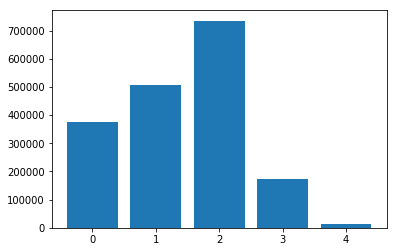

In [7]:
total_count = []

for index, traffic_period in enumerate(traffic_periods):
    total_count.append(traffic_period['number_people'].sum())
print(total_count)
plt.bar(x = range(len(total_count)), height = total_count)

Ignoring the first and the last period, based on the above notes, an interesting observation we can make from this plot is that in the Nov'15-Mar'16 period, the total number of workout sessions was more than twice that number in the same period of the next year (Nov'16-Mar'17). Said differently, the number of session workouts dropped by more than half one year after.

### Monthly statistics
We will increase the granularity of our analysis on a monthly basis.

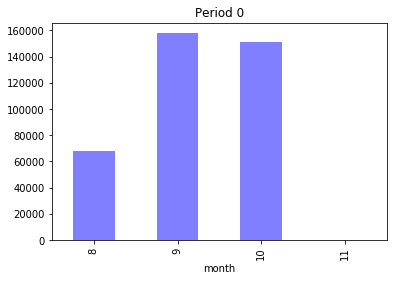

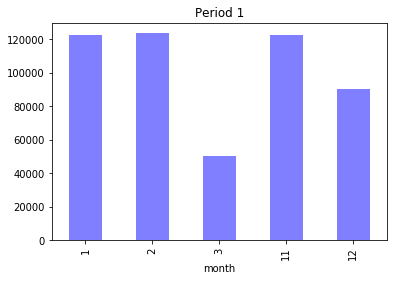

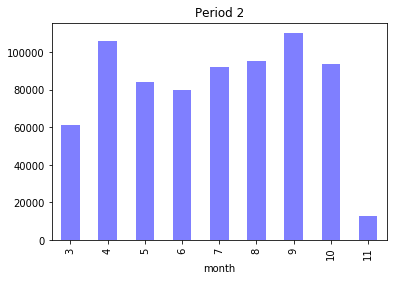

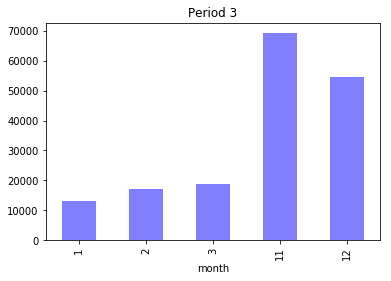

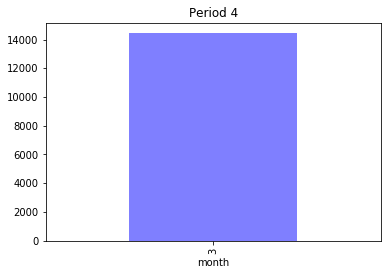

In [35]:
def plot_monthly_stats(traffic_period, index):
    #display(traffic_period.groupby('month')['number_people'].agg('sum'))
    traffic_period.groupby('month')['number_people'].agg('sum').plot.bar(color='blue', alpha=0.5)
    plt.title(f"Period {index}")
    plt.show()
    #traffic_period.hist(column = 'number_people', by='month')
for index, traffic_period in enumerate(traffic_periods):
    plot_monthly_stats(traffic_period, index)

# One month before and after DST
Let's now focus our analysis only on the month before and after the hour change, in order to look for more interesting pattern changes. 

In [41]:
for index in range(len(traffic_periods) - 1):
    period_before = traffic_periods[index]
    period_after = traffic_periods[index + 1]
    one_month_before_dst = period_before[period_before['date_utc'] >= (period_before['date_utc'].max() - timedelta(30))]
    one_month_after_dst = period_after[period_after['date_utc'] <= (period_after['date_utc'].min() + timedelta(30))]
    print(f"Time change #{index}")
    print(f"Data points one month before: {len(one_month_before_dst)}")
    print(f"Data points one month after: {len(one_month_after_dst)}")

Time change #0
Data points one month before: 2934
Data points one month after: 2905
Time change #1
Data points one month before: 2905
Data points one month after: 2948
Time change #2
Data points one month before: 4124
Data points one month after: 4212
Time change #3
Data points one month before: 1384
Data points one month after: 666


We will ignore the last change, becaue we only have 8 days available on the period after the March 2017 time change, and not enough data points.
In order to visualise this data, we could plot the distrubtion of the number of people on every day of the week. That makes sense from the perspective of our data domain (since most of the workouts programs are tailored on a week by week basis - ie Monday - Leg day, Friday - Arms day 💪)

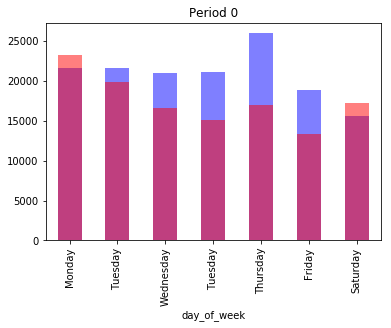

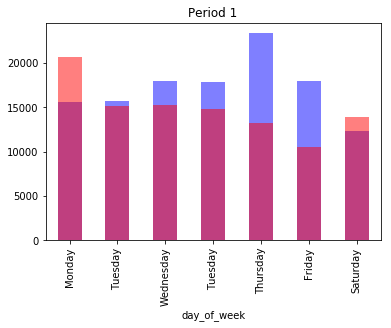

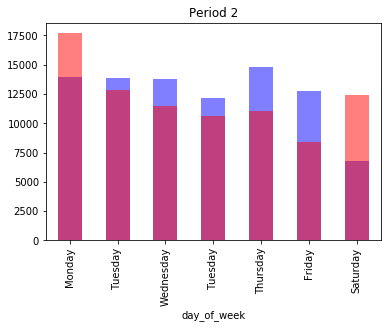

In [40]:
for index in range(len(traffic_periods) - 2):
    period_before = traffic_periods[index]
    period_after = traffic_periods[index + 1]
    one_month_before_dst = period_before[period_before['date_utc'] >= (period_before['date_utc'].max() - timedelta(30))]
    one_month_after_dst = period_after[period_after['date_utc'] <= (period_after['date_utc'].min() + timedelta(30))]
    ax = one_month_before_dst.groupby('day_of_week')['number_people'].agg('sum').plot.bar(color='blue', alpha=0.5)
    one_month_after_dst.groupby('day_of_week')['number_people'].agg('sum').plot.bar(color='red', alpha=0.5, ax = ax)
    plt.title(f"Period {index}")
    ax.set_xticklabels(["Monday", "Tuesday", "Wednesday", "Tuesday", "Thursday", "Friday", "Saturday", "Sunday"])
    plt.show()

We can see the results are pretty consistent. The distributions skews to the left, perhaps because people are thinking about going to the gym as early as possible. We can think of this as the "New Year's Resolution" effect when people are very motivated to start going to the gym an eating healthy right after the New Year's Eve, but they loose momentun in the following months.

## Heatmaps

Let's not try to plot a color matrix for each day of the week and for each hour.

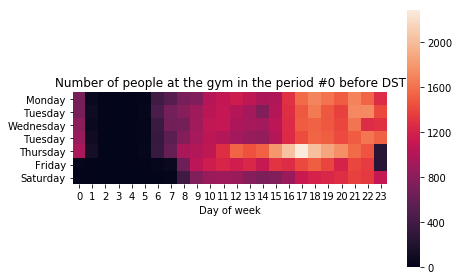

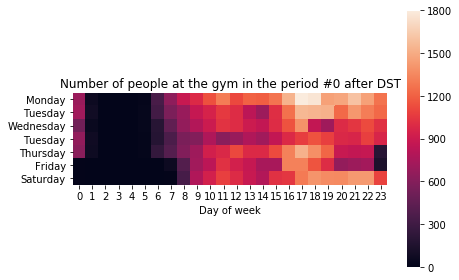

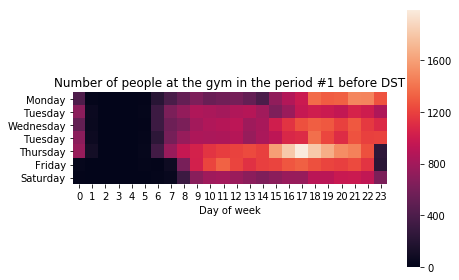

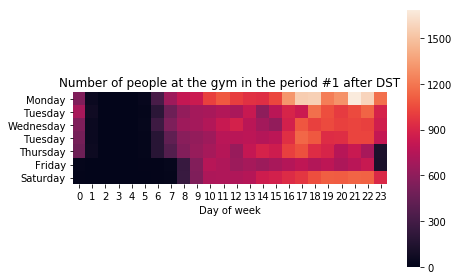

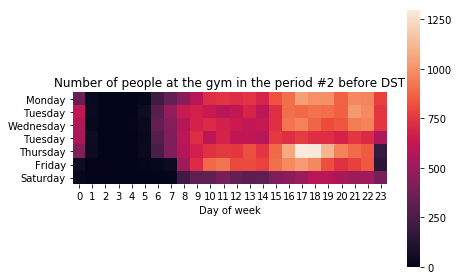

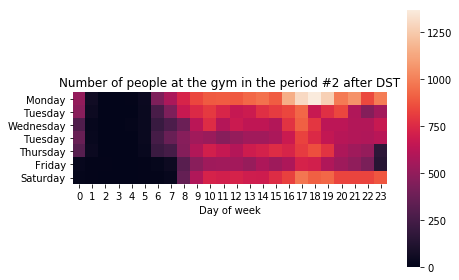

In [102]:
def plot_heatmap(df, index, after = False):
    myMap = np.zeros(shape = [7, 24])
    for row in df.iterrows():
        myMap[row[1]['day_of_week'], row[1]['hour']] += row[1]['number_people']
    ax = sns.heatmap(myMap, square=True)
    plt.tight_layout()
    if after:
        plt.title(f"Number of people at the gym in the period #{index} after DST")
    else:
        plt.title(f"Number of people at the gym in the period #{index} before DST")
    plt.xlabel("Day of week")
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=0)
    ax.set_yticklabels(["Monday", "Tuesday", "Wednesday", "Tuesday", "Thursday", "Friday", "Saturday", "Sunday"])
    plt.setp(ax.yaxis.get_majorticklabels(), rotation=0)
    plt.show()

for index in range(len(traffic_periods) - 2):
    period_before = traffic_periods[index]
    period_after = traffic_periods[index + 1]
    one_month_before_dst = period_before[period_before['date_utc'] >= (period_before['date_utc'].max() - timedelta(30))]
    one_month_after_dst = period_after[period_after['date_utc'] <= (period_after['date_utc'].min() + timedelta(30))]
    plot_heatmap(one_month_before_dst, index)
    plot_heatmap(one_month_after_dst, index, after = True)

It can be seen from this heatmaps that the number of coming early in the morning (6am) increases after the DST - which makes sense, and we were expecting that.

__A very interesting pattern that we notice is that on every change, the highest traffic at the gym before the change was always on Thursdays (white squares) afternoon, between 14-20, and the cluster after was always on Mondays on pretty much the same period.__

Let's now aggregate the days based on the hours.

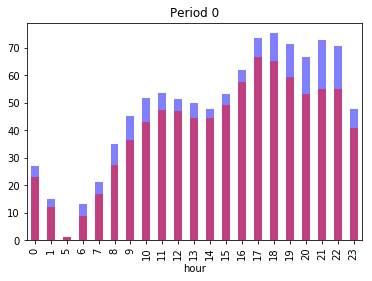

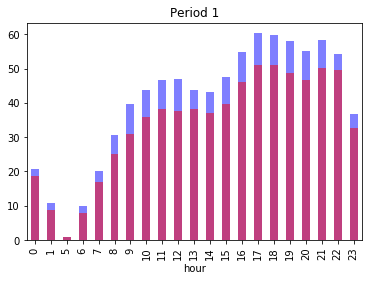

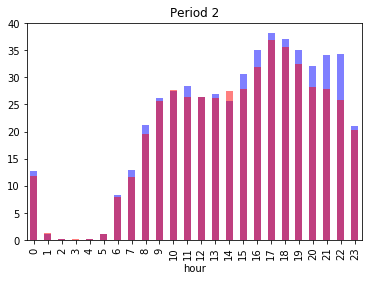

In [100]:
for index in range(len(traffic_periods) - 2):
    period_before = traffic_periods[index]
    period_after = traffic_periods[index + 1]
    one_month_before_dst = period_before[period_before['date_utc'] >= (period_before['date_utc'].max() - timedelta(30))]
    one_month_after_dst = period_after[period_after['date_utc'] <= (period_after['date_utc'].min() + timedelta(30))]
    ax = one_month_before_dst.groupby('hour')['number_people'].mean().plot.bar(color='blue', alpha=0.5)
    one_month_after_dst.groupby('hour')['number_people'].mean().plot.bar(color='red', alpha=0.5, ax = ax)
    plt.title(f"Period {index}")
    plt.show()

We can see that the distribution of the mean number of people on each our is decreasing with some very very rare cases. So, nothing very conclusive here.
